In [1]:
import os

import fitsio
import numpy as np
import pylab as plt

from astropy.io import fits
from astropy.wcs import WCS
from astropy.table import Table

import sep
import tractor

from astrometry.util.fits import fits_table
from astrometry.util.util import wcs_pv2sip_hdr

from tractor import NullWCS
from tractor.galaxy import *
from tractor.sersic import *
from tractor.psf import *
from tractor.ellipses import *

In [35]:
def make_plot(tim, mod, filename='tractor_test.png'):
    image = tim.getImage()
    
    # imshow arguments for images
    mn, mx = np.percentile(image, [25,99])
    ima = dict(interpolation='nearest', origin='lower',
               cmap='gray', vmin=mn, vmax=mx)
    
    # imshow arguments for chi images
    chia = dict(interpolation='nearest', origin='lower',
               cmap='gray', vmin=-5, vmax=+5)
    
    plt.clf()
    plt.subplot(131)
    plt.imshow(image, **ima)
    plt.xticks([]); plt.yticks([])
    plt.title('Data')
    
    plt.subplot(132)
    plt.imshow(mod, **ima)
    plt.xticks([]); plt.yticks([])
    plt.title('Model')
    
    plt.subplot(133)
    plt.imshow(image - mod, **ima)
    plt.xticks([]); plt.yticks([])
    plt.title('Residual')
    
    plt.show()
    plt.savefig(filename)

# Based on Dane's notebook

In [42]:
#open fits files

galaxy_dir = os.path.abspath('26_tractor_ready')

img_data = fits.open(os.path.join(galaxy_dir, 'img_data_crop_26.fits'))[0].data
sig_data = fits.open(os.path.join(galaxy_dir, 'sig_data_crop_26.fits'))[0].data

psf_data = fits.open(os.path.join(galaxy_dir, 'redadd_26_HSC-I_full_psf.fits'))[0].data
psf_obj = PixelizedPSF(psf_data, Lorder=5)
#psf_obj = NCircularGaussianPSF([2.5], [1.])

obj_cat = Table.read(os.path.join(galaxy_dir, 'tractor_26.fits'))

invvar_data = (1.0 / (sig_data ** 2.0))
#invvar_data[bad_data > 0] = np.nan

wcs_obj = NullWCS(pixscale=0.168)

In [49]:
tim = tractor.Image(data=img_data,
                    invvar=invvar_data,
                    psf=psf_obj,
                    wcs=wcs_obj,
                    sky=tractor.ConstantSky(0.0),
                    photocal=tractor.NullPhotoCal(), 
            )

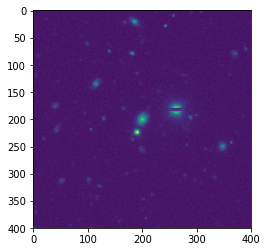

In [50]:
plt.imshow(np.arcsinh(tim.getImage()))
plt.show()

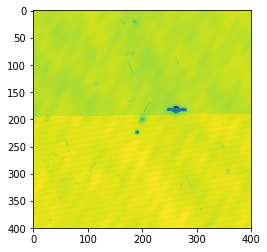

In [51]:
plt.imshow(np.arcsinh(tim.getInvvar()))
plt.show()

In [52]:
sources=[]

for obj in obj_cat:
    # if the object is a point source, add it as such
    if obj['point_source'] > 0.0:
        sources.append(tractor.PointSource(tractor.PixPos(obj['x'], obj['y']),
                                           tractor.Flux(obj['flux'])) )
    else:
        sources.append(tractor.DevGalaxy(tractor.PixPos(obj['x'], obj['y']),
                                         tractor.Flux(obj['flux']),
                                         GalaxyShape(obj['a'] / 2.0, 
                                                     (obj['b'] / obj['a']),
                                                     (180.0 - obj['theta'] * 180.0 / np.pi))))

In [53]:
trac_obj = Tractor([tim], sources)

trac_mod = trac_obj.getModelImage(0, minsb=0., srcs=sources)

In [36]:
make_plot(tim, trac_mod, filename='tractor_26_init.png')

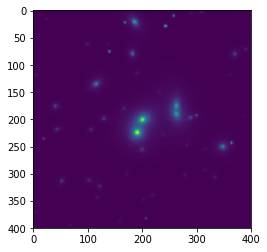

In [54]:
plt.imshow(np.arcsinh(trac_mod))
plt.show()

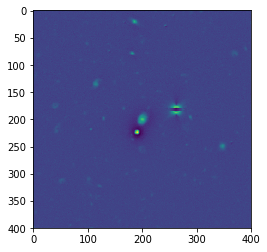

In [55]:
plt.imshow(np.arcsinh(img_data - trac_mod))
plt.show()

In [30]:
# We don't want to fit for any of the image calibration properties:
trac_obj.freezeParam('images')

In [32]:
trac_obj.optimize_loop()

{'steps': 11}

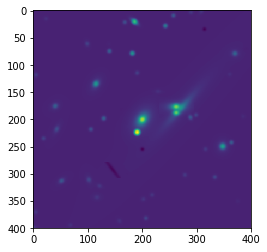

In [33]:
trac_mod_opt = trac_obj.getModelImage(0, minsb=0., srcs=sources)

plt.imshow(np.arcsinh(trac_mod_opt))
plt.show()

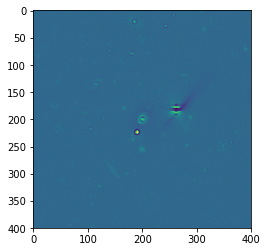

In [34]:
trac_mod_opt = trac_obj.getModelImage(0, minsb=0., srcs=sources)

plt.imshow(np.arcsinh(img_data - trac_mod_opt))
plt.show()